In [2]:
# 1. Imports
!pip install pandas scikit-learn matplotlib seaborn

import pandas as pd, numpy as np, glob, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [3]:


csv_path = "../Dataset"            # one level up from the notebook
csv_files = glob.glob(os.path.join(csv_path, "*.csv")) \
          + glob.glob(os.path.join(csv_path, "*.CSV"))

if not csv_files:
    raise FileNotFoundError("No CSV files found. Check the path.")

df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

print(f"✅ Loaded {len(df)} rows from {len(csv_files)} CSV files.")
display(df.head())



C:\Users\omrih\AppData\Local\Temp\ipykernel_13660\3723721796.py:8: DtypeWarning: Columns (20,21,43,44,45,62,65,71,73,77,78,79,80,82,84,85,87,90,91,92,93,94,96,98,99,100,101,102,103,104,107,108,109,110,111,112,113,114,115,116,117,118,153,155,157,158,159,160,161,162,163,164,166,167,168,169,170,171,172,173,175,176,177,178,180,181,183,184,185,189,190,192,193,194,195,197,200,201,202,203,204,205,206,209,210,211,212,213,215,217,247,248,250,251) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)
C:\Users\omrih\AppData\Local\Temp\ipykernel_13660\3723721796.py:8: DtypeWarning: Columns (71,73,77,78,79,80,82,84,85,87,90,91,92,93,98,99,100,101,102,103,104,105,107,108,109,110,111,112,113,114,115,116,117,119,120,137,141,146,148,149,151,166,167,168,178,180,183,184,185,189,190,192,193,194,195,196,197,200,201,202,203,204,205,206,209,210,211,212,213,217,218,219,247,248,249,250,251) have mixed types. Specify dt

✅ Loaded 600000 rows from 12 CSV files.


,frame.encap_type,frame.len,frame.number,frame.time,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,...,tls.app_data_proto,tls.compress_certificate.compressed_certificate_message.length,tls.connection_id,tls.handshake.extension.type,tls.handshake.extensions_key_share_group,tls.handshake.session_ticket_length,tls.handshake.version,tls.record.content_type,tls.record.version,Label
0,23,76,1500001,Dec 18- 2020 17:52:02.181718000 GTB Standard Time,0.000390,0.000390,1608306722,543.699118,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
1,23,70,1500002,Dec 18- 2020 17:52:02.181722000 GTB Standard Time,0.000004,0.000004,1608306722,543.699122,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
2,23,76,1500003,Dec 18- 2020 17:52:02.182104000 GTB Standard Time,0.000382,0.000382,1608306722,543.699504,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
3,23,70,1500004,Dec 18- 2020 17:52:02.182108000 GTB Standard Time,0.000004,0.000004,1608306722,543.699508,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal
4,23,1610,1500005,Dec 18- 2020 17:52:02.182287000 GTB Standard Time,0.000179,0.000179,1608306722,543.699687,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal


In [4]:
# Set label column
label_col = 'Label'
# Show label distribution
print(f"\n Label distribution in column '{label_col}':")
print(df[label_col].value_counts())



 Label distribution in column 'Label':
Label
Normal       530486
Evil_Twin     42158
Deauth        27356
Name: count, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# 1. Drop duplicate rows
df = df.drop_duplicates()

# 2. Replace inf values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# 3. Drop columns with more than 10% missing values
threshold = 0.9 * len(df)
df = df.dropna(axis=1, thresh=threshold)

# 4. Fill remaining NaN values with 0
df = df.fillna(0)

# 5. Encode labels
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])

# 6. Split features and labels
X = df.drop(columns=["Label"])
X = X.select_dtypes(include=[np.number])
y = df["Label"]

# 6b. Keep only the top important features (as seen in the plot)
selected_features = [
    'wlan.fc.type',
    'wlan_radio.data_rate',
    'frame.number',
    'frame.len',
    'radiotap.timestamp.ts',
    'wlan.fc.subtype',
    'wlan.fc.protected',
    'wlan_radio.signal_dbm',
    'wlan_radio.duration',
    'radiotap.dbm_antsignal',
    'wlan_radio.phy',
    'frame.time_epoch',
    'radiotap.length',
    'frame.time_delta_displayed',
    'frame.time_relative',
    'frame.time_delta',
    'wlan.duration',
    'wlan.fc.retry',
    'wlan.fc.pwrmgt',
    'wlan.fc.moredata',
    'wlan.fc.order',
    'wlan.fc.frag',
    'radiotap.channel.freq',
    'radiotap.channel.flags.ofdm',
    'radiotap.channel.flags.cck',
    'wlan_radio.channel',
    'wlan_radio.frequency',
    'frame.encap_type'
]

# Retain only selected features
X = X[selected_features]


# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 8. Define hyperparameter grid
param_dist = {
    'n_estimators': [200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini'],
    'max_features': ['sqrt', 'log2']
}

# 9. Create and tune Random Forest with RandomizedSearchCV
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=8,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# 10. Evaluate best model
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("📊 Best Hyperparameters:")
print(random_search.best_params_)


📊 Best Hyperparameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


In [6]:
target_names = ['Deauth', 'Evil_Twin', 'Normal']

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


print("🧩 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\n🎯 Accuracy: {accuracy_score(y_test, y_pred):.4f}")



✅ Classification Report:
              precision    recall  f1-score   support

      Deauth       1.00      1.00      1.00      2735
   Evil_Twin       1.00      1.00      1.00      4216
      Normal       1.00      1.00      1.00     53049

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

🧩 Confusion Matrix:
[[ 2735     0     0]
 [    0  4216     0]
 [    0     5 53044]]

🎯 Accuracy: 0.9999


In [7]:
import joblib
joblib.dump(best_rf, "trained_rf_model.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

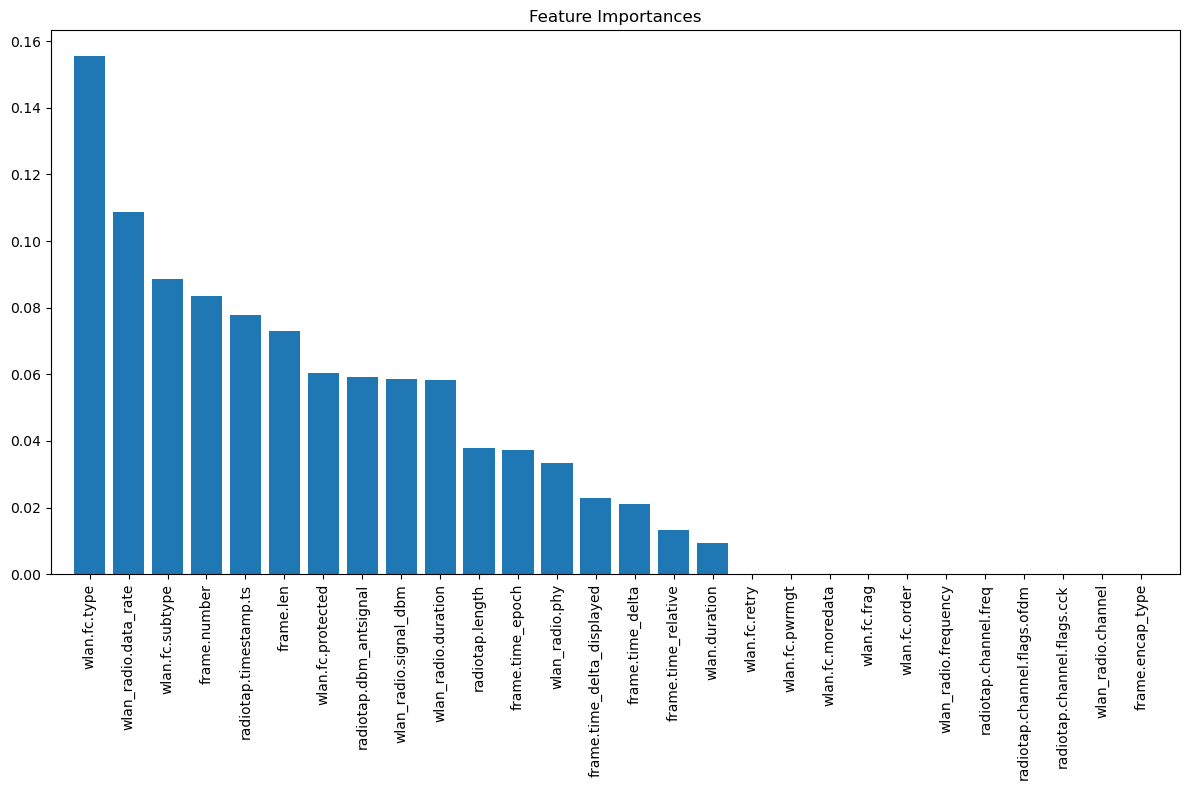

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from best trained model
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
